In [12]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import itertools

from datetime import datetime
from matplotlib.dates import DateFormatter

import statsmodels.api as sm

#Seaborn for beautiful graphs
import seaborn as sns
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

#import seaborn as sns
#sns.set_style('whitegrid')
#sns.set_context('paper')

from pandas_profiling import ProfileReport

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import math
import statistics

In [13]:
# Reading the data 
df = pd.read_csv('Datetime_kwh_hr_2001_3103.csv')
df['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['Datetime']]

# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
df = df.groupby('Datetime', as_index=False)['kwh'].mean()

# Sorting the values
df.sort_values('Datetime', inplace=True)

In [14]:
# Dataframe Profiling
#prof = ProfileReport(df)
#prof.to_notebook_iframe()

In [15]:
#Setting index date
df.set_index(df['Datetime'],inplace=True)
#Dropping column Datetime
df.drop('Datetime',axis = 1,inplace=True)

In [16]:
df = df.resample('D').sum()
df

,kwh
Datetime,
2020-01-20,3.8529
2020-01-21,4.6259
2020-01-22,3.9684
2020-01-23,4.2741
2020-01-24,5.1785
...,...
2020-03-27,3.9272
2020-03-28,4.5493
2020-03-29,3.5194


In [17]:
# Removing data values from dataframe
df.drop(df[df.kwh < 2].index, inplace=True)
df.drop(df[df.kwh > 7].index, inplace=True)

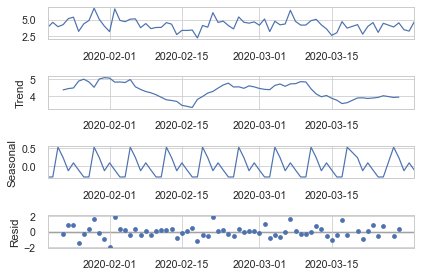

In [18]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period = 7)
#decompfreq = 24*60/60*7
fig = decomposition.plot()
plt.show()

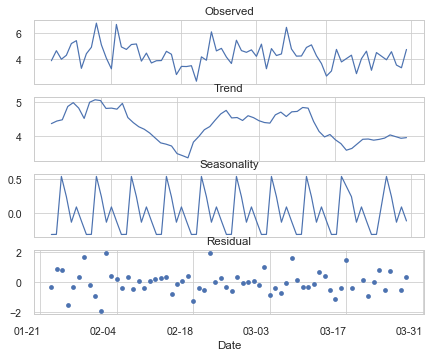

In [19]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(7,6))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonality')
decomposition.resid.plot(ax=ax4, title='Residual', style=['o'])
# Define the date format
date_form = DateFormatter("%m-%d")
ax4.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax4.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.xticks(rotation=0)
ax4.set(xlabel="Date")
plt.show()

fig.savefig('TSDecomposeDay.png', format='png', dpi=300)

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [124]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append 는 일반 list append 와 다르게 이렇게 지정해주어야한다.
            del temp
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:402.12161855321676
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:295.6288127955441
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:197.46500791022922
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:133.99702216355283
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:197.95441604275942
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:170.3996219174234
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:140.81077036605913
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:135.2094766204634
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:335.34748812344054
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:240.13625262175736
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:187.5876722166284
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:124.67744391957532
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:192.9851842640522
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:168.5830562170973
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:141.5418760889108
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:123.82829242057974
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:210.8451716601884
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:165.5059191202957
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:20

In [125]:
m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

mod = sm.tsa.statespace.SARIMAX(df,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                kwh   No. Observations:                   70
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -56.625
Date:                            Tue, 21 Jul 2020   AIC                            123.249
Time:                                    09:49:53   BIC                            132.170
Sample:                                         0   HQIC                           126.558
                                             - 70                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6218      0.343      1.813      0.070      -0.050       1.294
ma.L1         -0.3757      0.427   

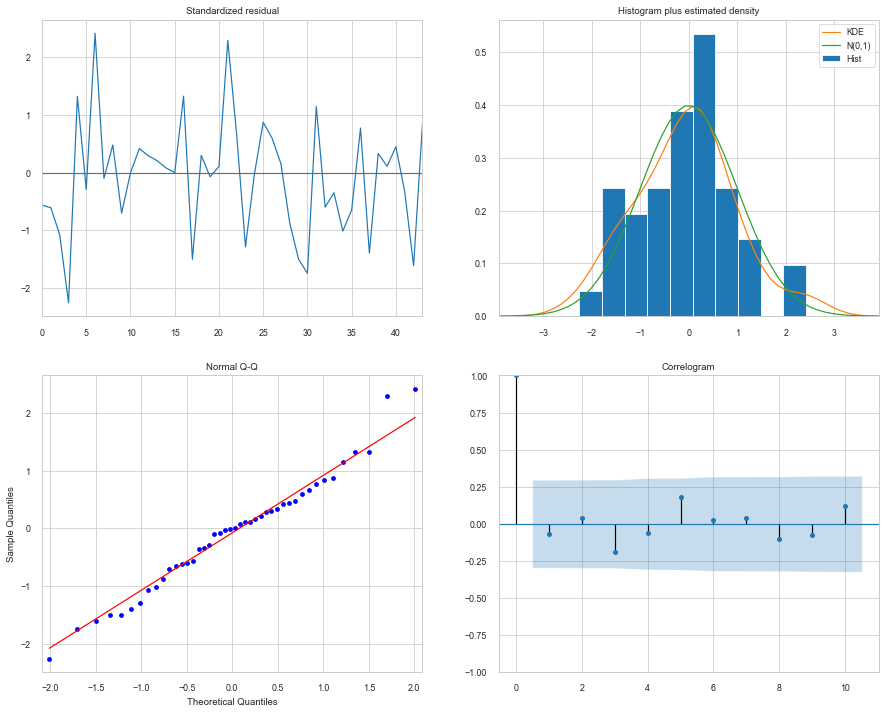

In [126]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [1]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-18'), dynamic=False)
pred_ci = pred.conf_int()

ax = df['2020-03-21':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('kwh')
plt.legend()

plt.show()

NameError: name 'results' is not defined

In [61]:
#expected = df['2020-03-18':]

In [128]:
#Accuracy metrics for the forecast: forecast bias, mean absolute error, mean squared error, and root mean square error
expected = df['2020-03-18':]['kwh']
predictions = pred.predicted_mean
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
#bias = sum(forecast_errors) * 1.0/len(expected)
#mae = mean_absolute_error(expected, predictions)
#mean_squared_error = mean(forecast_errors^2)
#rmse = sqrt(mse)
#print('Forecast Errors: %s' % forecast_errors)
print('Bias: %f' % bias)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

Bias: -0.233694
MAE: 0.568819
MSE: 0.455672
RMSE: 0.666896


In [129]:
df_forecasted = pred.predicted_mean
df_truth = df['2020-03-18':]['kwh']

# Compute the mean square error
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.44


In [103]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.67


In [104]:
pred_uc = results.get_forecast(steps=25)
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('kwh')

plt.legend()
plt.show()

ValueError: view limit minimum -36802.25 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36802.25 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1008x504 with 1 Axes>

In [106]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-03-18'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

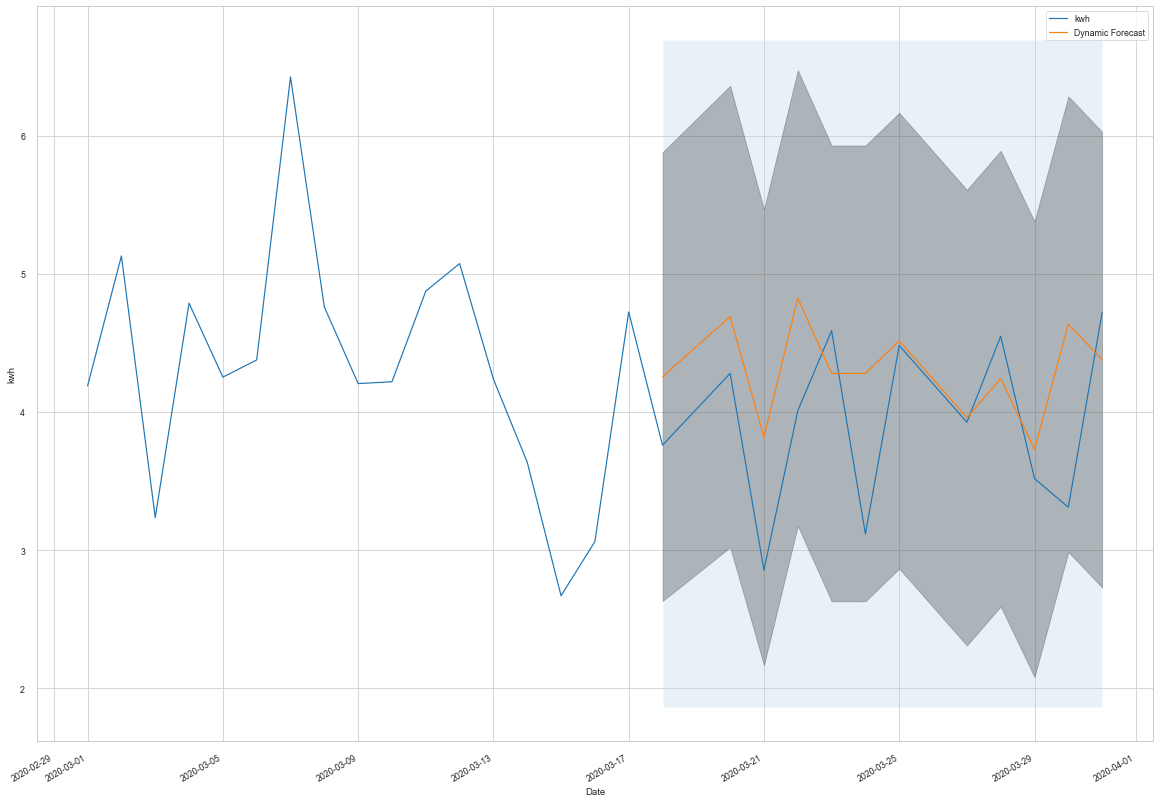

In [108]:
ax = df['2020-03':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-03-18'), df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('kwh')

plt.legend()
plt.show()

In [109]:
# Extract the predicted and true values of our time series
df_forecasted = pred_dynamic.predicted_mean
df_truth = df['2020-03-18':]['kwh']

# Compute the mean square error
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.46


In [110]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.68
